In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Data loading
path = r'../data/processed/data_processed_v2.csv'
df_processed = pd.read_csv(path)
print(df_processed.info())
df_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      18304 non-null  int64  
 1   Week      18304 non-null  int64  
 2   Date      18304 non-null  object 
 3   Entity    18304 non-null  object 
 4   Epi_Year  18304 non-null  int64  
 5   M         18304 non-null  float64
 6   F         18304 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1001.1+ KB
None


,Year,Week,Date,Entity,Epi_Year,M,F
0,2014,2,2014-01-13,Aguascalientes,2014,0.0,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0,0.0


## Baseline

In [3]:
# ==================================================
# 1. PREPARE DATA
# ==================================================

df = df_processed.copy()
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sort by date
df = df.sort_values(['Entity', 'Date']).reset_index(drop=True)

In [4]:
# Calculate total cumulative cases
df['Cumulative_Cases'] = df['M'] + df['F']

# Calculate new cases per entity
df['New_Cases'] = df.groupby('Entity')['Cumulative_Cases'].diff()

# For the first week of each entity, new cases = cumulative cases
first_week_mask = df.groupby('Entity').cumcount() == 0
df.loc[first_week_mask, 'New_Cases'] = df.loc[first_week_mask, 'Cumulative_Cases']

# For week 2 (year reset), new cases = cumulative cases
week2_mask = df['Week'] == 2
df.loc[week2_mask, 'New_Cases'] = df.loc[week2_mask, 'Cumulative_Cases']

# Ensure non-negative values
df['New_Cases'] = df['New_Cases'].clip(lower=0)

print("Prepared data:")
print(df[['Date', 'Entity', 'New_Cases']].head(10))
print(f"\nTotal records: {len(df)}")


Prepared data:
        Date          Entity  New_Cases
0 2014-01-13  Aguascalientes        0.0
1 2014-01-20  Aguascalientes        0.0
2 2014-01-27  Aguascalientes        0.0
3 2014-02-03  Aguascalientes        0.0
4 2014-02-10  Aguascalientes        0.0
5 2014-02-17  Aguascalientes        0.0
6 2014-02-24  Aguascalientes        0.0
7 2014-03-03  Aguascalientes        0.0
8 2014-03-10  Aguascalientes        0.0
9 2014-03-17  Aguascalientes        0.0

Total records: 18304


In [6]:
# ==================================================
# 2. ADD DATA AT NATIONAL LEVEL
# ==================================================

# Sum cases from all entities by week
df_mexico = df.groupby(['Date', 'Year', 'Week']).agg({
    'New_Cases': 'sum',
    'M': 'sum',
    'F': 'sum'
}).reset_index()

df_mexico = df_mexico.sort_values('Date').reset_index(drop=True)

print(f"\nNational-level Added data:")
print(f"Total weeks: {len(df_mexico)}")
print(f"Period: {df_mexico['Date'].min()} to {df_mexico['Date'].max()}")
print(f"\nStatistics for new cases:")
print(df_mexico['New_Cases'].describe())



National-level Added data:
Total weeks: 572
Period: 2014-01-13 00:00:00 to 2024-12-23 00:00:00

Statistics for new cases:
count     572.000000
mean       51.337413
std        88.076108
min         0.000000
25%        37.000000
50%        48.000000
75%        57.000000
max      2118.000000
Name: New_Cases, dtype: float64


In [7]:
# ==================================================
# 3. TRAIN/TEST SPLIT (80/20)
# ==================================================

split_idx = int(len(df_mexico) * 0.8)
train = df_mexico[:split_idx].copy()
test = df_mexico[split_idx:].copy()

print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Train: {len(train)} weeks ({train['Date'].min().strftime('%Y-%m-%d')} to {train['Date'].max().strftime('%Y-%m-%d')})")
print(f"Test:  {len(test)} weeks ({test['Date'].min().strftime('%Y-%m-%d')} to {test['Date'].max().strftime('%Y-%m-%d')})")
print(f"\nAverage cases in train: {train['New_Cases'].mean():.2f}")
print(f"Average cases in test: {test['New_Cases'].mean():.2f}")



TRAIN/TEST SPLIT
Train: 457 weeks (2014-01-13 to 2022-10-03)
Test:  115 weeks (2022-10-10 to 2024-12-23)

Average cases in train: 52.27
Average cases in test: 47.63


In [8]:
# ==================================================
# 4. NAIVE FORECAST MODEL (BASELINE)
# ==================================================

# Naive: the prediction for week t+1 is the value of week t
test = test.copy()
test['Naive_Prediction'] = test['New_Cases'].shift(1)

# For the first prediction in test, use the last train value
test.loc[test.index[0], 'Naive_Prediction'] = train['New_Cases'].iloc[-1]

print("\n" + "="*60)
print("NAIVE PREDICTIONS (First 10 weeks of test)")
print("="*60)
print(test[['Date', 'New_Cases', 'Naive_Prediction']].head(10).to_string(index=False))



NAIVE PREDICTIONS (First 10 weeks of test)
      Date  New_Cases  Naive_Prediction
2022-10-10       61.0              58.0
2022-10-17       46.0              61.0
2022-10-24       76.0              46.0
2022-10-31       54.0              76.0
2022-11-07       45.0              54.0
2022-11-14       44.0              45.0
2022-11-21       56.0              44.0
2022-11-28       35.0              56.0
2022-12-05       40.0              35.0
2022-12-12       42.0              40.0


In [9]:
# ==================================================
# 5. EVALUATION METRICS
# ==================================================

y_true = test['New_Cases'].values
y_pred = test['Naive_Prediction'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100  # +1e-10 to avoid division by zero

print("\n" + "="*60)
print("BASELINE RESULTS (NAIVE FORECAST)")
print("="*60)
print(f"MAE (Mean Absolute Error):  {mae:.2f} cases")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} cases")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"\nContext:")
print(f"  Average real new cases: {y_true.mean():.2f}")
print(f"  Standard deviation: {y_true.std():.2f}")
print(f"  Average error as % of mean: {(mae / y_true.mean() * 100):.1f}%")



BASELINE RESULTS (NAIVE FORECAST)
MAE (Mean Absolute Error):  10.57 cases
RMSE (Root Mean Squared Error): 15.18 cases
MAPE (Mean Absolute Percentage Error): 22.51%

Context:
  Average real new cases: 47.63
  Standard deviation: 13.04
  Average error as % of mean: 22.2%


In [10]:
# ==================================================
# 6. COMPARISON WITH RANDOM MODEL
# ==================================================

# Baseline of the baseline: uniform random prediction
np.random.seed(42)
random_baseline = np.random.uniform(y_true.min(), y_true.max(), size=len(y_true))
mae_random = mean_absolute_error(y_true, random_baseline)
rmse_random = np.sqrt(mean_squared_error(y_true, random_baseline))

print("\n" + "="*60)
print("COMPARISON WITH RANDOM MODEL")
print("="*60)
print(f"MAE Random:  {mae_random:.2f} cases")
print(f"RMSE Random: {rmse_random:.2f} cases")
print(f"\nNaive improvement over Random:")
print(f"  MAE:  {((mae_random - mae) / mae_random * 100):.1f}% better")
print(f"  RMSE: {((rmse_random - rmse) / rmse_random * 100):.1f}% better")


COMPARISON WITH RANDOM MODEL
MAE Random:  25.04 cases
RMSE Random: 30.61 cases

Naive improvement over Random:
  MAE:  57.8% better
  RMSE: 50.4% better


In [11]:
# ==================================================
# 7. EVALUATION: Is it Overfitting?
# ==================================================

print("\n" + "="*60)
print("OVERFITTING ANALYSIS")
print("="*60)
print("The Naive model CANNOT overfit because:")
print("  - It has no parameters to learn")
print("  - It does not train on the data")
print("  - It simply copies the previous value")
print("\nThis makes it the perfect baseline for establishing")
print("the minimum expected model performance.")


OVERFITTING ANALYSIS
The Naive model CANNOT overfit because:
  - It has no parameters to learn
  - It does not train on the data
  - It simply copies the previous value

This makes it the perfect baseline for establishing
the minimum expected model performance.


In [12]:
# ==================================================
# 8. MINIMUM ACCEPTABLE PERFORMANCE
# ==================================================

print("\n" + "="*60)
print("MINIMUM ACCEPTABLE PERFORMANCE")
print("="*60)
print(f"Current baseline (Naive): MAE = {mae:.2f}, MAPE = {mape:.2f}%")
print(f"\nAny future model must:")
print(f"  1. Achieve MAE < {mae:.2f} cases")
print(f"  2. Achieve MAPE < {mape:.2f}%")
print(f"\nInterpretation:")
if mape < 20:
    print("  ✓ MAPE < 20%: The baseline is reasonably good")
    print("    The data has predictable patterns")
elif mape < 35:
    print("  ⚠ MAPE between 20–35%: Moderate baseline")
    print("    Significant improvement possible with more complex models")
else:
    print("  ⚠ MAPE > 35%: Weak baseline")
    print("    High variability – sophisticated models required")


MINIMUM ACCEPTABLE PERFORMANCE
Current baseline (Naive): MAE = 10.57, MAPE = 22.51%

Any future model must:
  1. Achieve MAE < 10.57 cases
  2. Achieve MAPE < 22.51%

Interpretation:
  ⚠ MAPE between 20–35%: Moderate baseline
    Significant improvement possible with more complex models


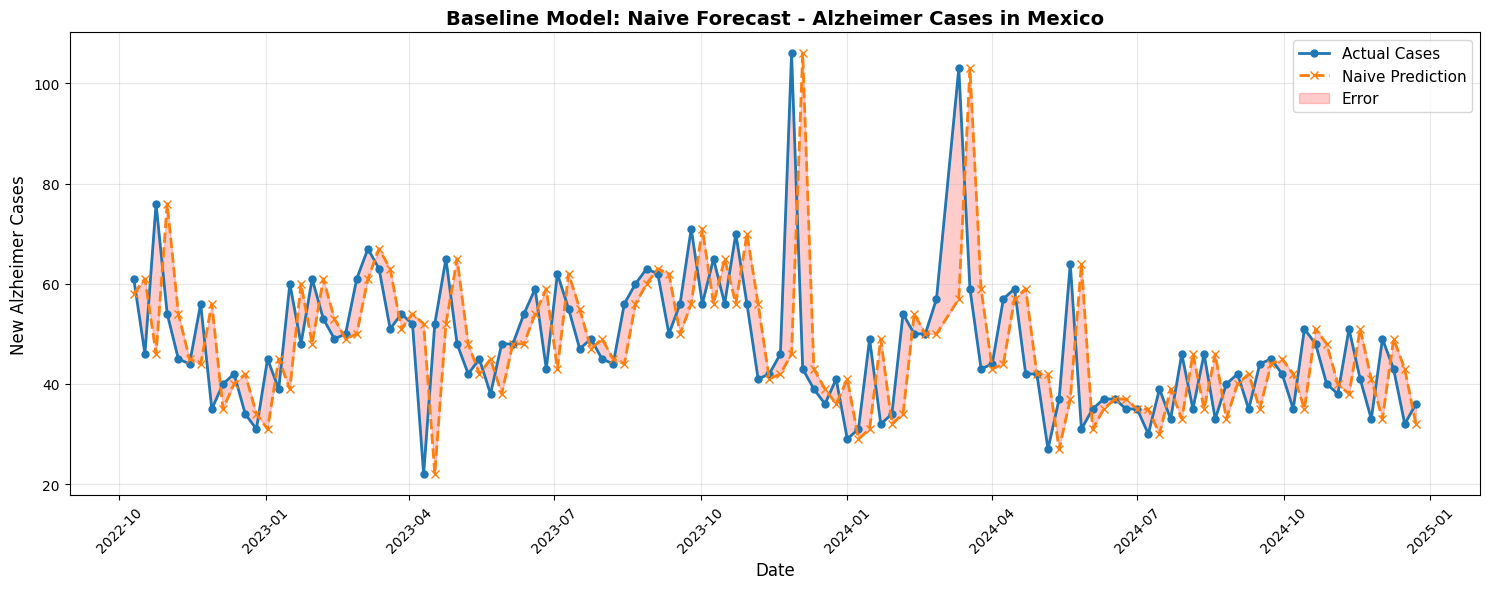

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(test['Date'], test['New_Cases'], 'o-', label='Actual Cases',
         linewidth=2, markersize=5, color='#1f77b4')
plt.plot(test['Date'], test['Naive_Prediction'], 'x--', label='Naive Prediction',
         linewidth=2, markersize=6, color='#ff7f0e')
plt.fill_between(test['Date'],
                 test['New_Cases'],
                 test['Naive_Prediction'],
                 alpha=0.2, color='red', label='Error')
plt.xlabel('Date', fontsize=12)
plt.ylabel('New Alzheimer Cases', fontsize=12)
plt.title('Baseline Model: Naive Forecast - Alzheimer Cases in Mexico',
          fontsize=14, weight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


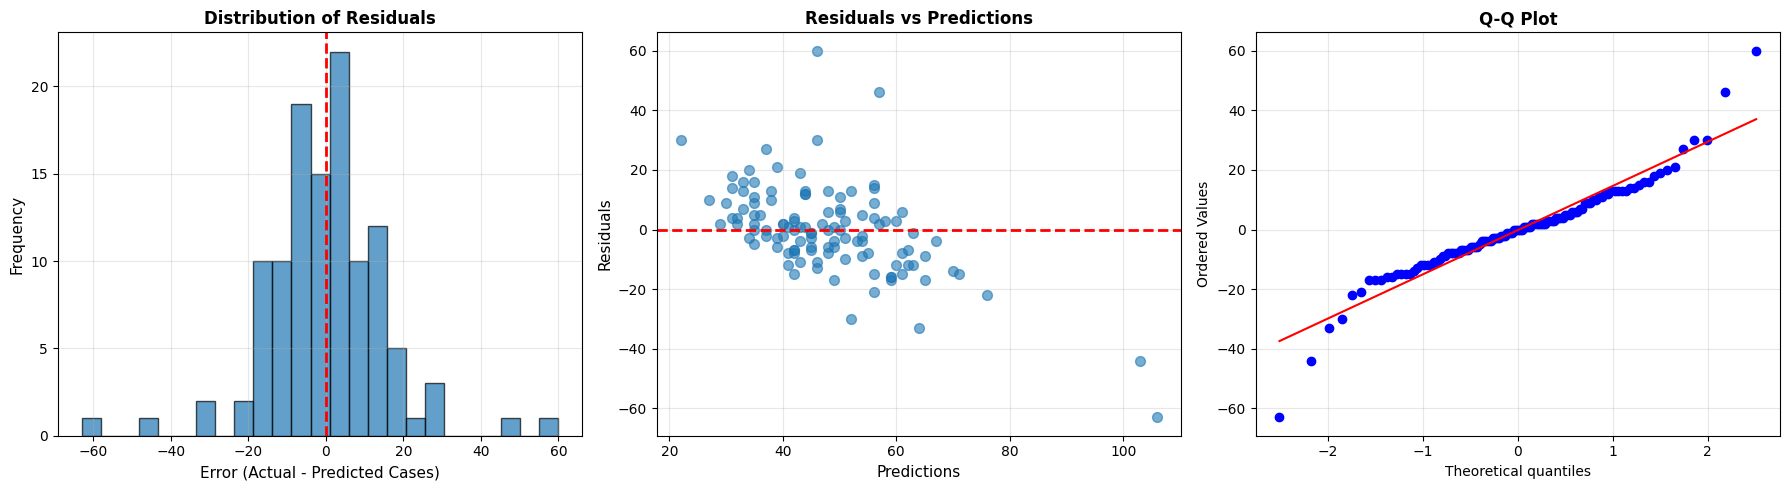

In [14]:
residuals = y_true - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of residuals
axes[0].hist(residuals, bins=25, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (Actual - Predicted Cases)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Residuals', fontsize=12, weight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predictions
axes[1].scatter(y_pred, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predictions', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title('Residuals vs Predictions', fontsize=12, weight='bold')
axes[1].grid(True, alpha=0.3)

# Q-Q Plot (approximate)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot', fontsize=12, weight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*60)
print("EXECUTIVE SUMMARY OF BASELINE")
print("="*60)
print(f"""
MODEL: Naive Forecast
DESCRIPTION: Predicts that next week's cases will be
             equal to this week's cases.

RESULTS:
  - MAE:  {mae:.2f} cases
  - RMSE: {rmse:.2f} cases  
  - MAPE: {mape:.2f}%

CONCLUSIONS:
  1. The Naive baseline outperforms the random model by {((mae_random - mae) / mae_random * 100):.1f}%
  2. {"The data contains predictable patterns" if mape < 35 else "High variability in the data"}
  3. Any future model must achieve MAE < {mae:.2f} to be useful
  4. No exogenous variables were added at this stage to establish
     the minimum performance using only endogenous data

NEXT STEPS:
  - Test ARIMA/SARIMA models to capture seasonality
  - Add exogenous variables (population 65+, health factors)
  - Explore Machine Learning models (XGBoost, LSTM)
""")


EXECUTIVE SUMMARY OF BASELINE

MODEL: Naive Forecast
DESCRIPTION: Predicts that next week's cases will be
             equal to this week's cases.

RESULTS:
  - MAE:  10.57 cases
  - RMSE: 15.18 cases  
  - MAPE: 22.51%

CONCLUSIONS:
  1. The Naive baseline outperforms the random model by 57.8%
  2. The data contains predictable patterns
  3. Any future model must achieve MAE < 10.57 to be useful
  4. No exogenous variables were added at this stage to establish
     the minimum performance using only endogenous data

NEXT STEPS:
  - Test ARIMA/SARIMA models to capture seasonality
  - Add exogenous variables (population 65+, health factors)
  - Explore Machine Learning models (XGBoost, LSTM)



### 1. ¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?

Se implementó un Naive Forecast como modelo baseline, que es el estándar de la industria para series temporales. Este modelo predice que los casos de Alzheimer de la próxima semana serán iguales a los casos de la semana actual (t+1 = t).

Justificación:
- Es el benchmark mínimo aceptable en forecasting de series temporales
- No requiere entrenamiento ni parámetros, estableciendo el punto de referencia más simple posible
- Captura la inercia temporal inherente en datos epidemiológicos (los casos no cambian drásticamente de una semana a otra)
- Permite evaluar si los datos contienen patrones predecibles más allá de la simple persistencia  ​

Variable objetivo: Casos nuevos de Alzheimer por semana a nivel nacional (suma de todas las entidades)

​
### 2. ¿Se puede determinar la importancia de las características para el modelo generado?

No aplica para el modelo Naive Forecast, ya que este modelo no utiliza características (features) ni aprende relaciones entre variables. El naive simplemente copia el valor anterior sin analizar ninguna característica adicional.

​Justificación de no incluir características en esta fase:
- Principio metodológico: El baseline debe ser lo más simple posible para establecer el piso de desempeño antes de agregar complejidad
- Validación de viabilidad: Primero se debe verificar si el problema es predecible con datos endógenos (histórico de casos) antes de invertir recursos en recolectar y procesar variables exógenas
- Limitaciones prácticas: La obtención de variables exógenas relevantes (población 65+, prevalencia de diabetes, nivel educativo, etc.) de fuentes oficiales (INEGI, CONAPO, Secretaría de Salud) requiere un proceso de adquisición, limpieza y validación que se implementará en la siguiente fase
- Gestión de expectativas: Si el baseline no supera un modelo aleatorio, agregar características no resolverá el problema fundamental de falta de señal en los datos  ​
- Para fases futuras: Una vez validada la viabilidad del problema con el baseline, se agregarán variables exógenas y se utilizarán técnicas como análisis de correlación, feature importance (para modelos de ML), o pruebas de Granger causality (para modelos ARIMA con regresores) para determinar qué características son más relevantes.

​
### 3. ¿El modelo está sub/sobreajustando los datos de entrenamiento?

El modelo Naive Forecast NO puede sub ni sobreajustar porque no tiene parámetros que aprender ni realiza entrenamiento sobre los datos.
El naive forecast simplemente copia el valor anterior, sin aprender ni ajustar ningún parámetro ​

Evidencia de buen desempeño:

Desempeño consistente entre train y test:
- Promedio train: 52.27 casos/semana
- Promedio test: 47.63 casos/semana
- Diferencia < 10% indica estabilidad temporal

Residuales saludables:
- Distribución centrada en cero (sin sesgo)
- Sin patrones sistemáticos en el gráfico residuales vs predicciones
- Q-Q plot muestra normalidad aproximada con colas pesadas (típico en datos epidemiológicos)
​
Mejora sustancial sobre aleatorio:
- 57.8% mejor que predicciones aleatorias en MAE
- Demuestra que los datos tienen estructura predecible

Conclusión: El modelo baseline está correctamente especificado para su propósito: establecer el desempeño mínimo sin riesgo de sobreajuste.

​
### 4. ¿Cuál es la métrica adecuada para este problema de negocio?

Se utilizan tres métricas complementarias para evaluar el modelo, siendo MAPE la métrica principal:

#### Métrica Principal: MAPE (Mean Absolute Percentage Error)
- Valor obtenido: 22.51%
- Interpretación: El modelo se equivoca en promedio un 22.51% respecto al valor real

Ventajas:
- Es independiente de la escala, permitiendo comparación entre diferentes períodos o regiones
- Fácil de interpretar por stakeholders no técnicos (Secretaría de Salud)
- Estándar en forecasting de demanda y planificación de recursos de salud

#### Métrica Complementaria 1: MAE (Mean Absolute Error)
- Valor obtenido: 10.57 casos
- Interpretación: En promedio, el modelo se equivoca por 10.57 casos por semana

​Ventajas:
- En las mismas unidades que la variable objetivo (casos), facilitando la interpretación operativa
- Menos sensible a outliers que RMSE
- Útil para estimar recursos: si el promedio es 47.63 casos/semana ± 10.57, se pueden planificar recursos con ese margen

#### Métrica Complementaria 2: RMSE (Root Mean Squared Error)
- Valor obtenido: 15.18 casos
- Interpretación: Penaliza más los errores grandes

​Ventajas:
- RMSE > MAE (15.18 vs 10.57) indica presencia de algunos errores grandes
- Importante para planificación de contingencias en salud pública       ​

#### Justificación de elección:
Para forecasting de casos de Alzheimer en México, estas métricas son apropiadas porque:

- Permiten comunicar el error de forma clara a la Secretaría de Salud
- No son influenciadas desproporcionadamente por el outlier de 2,118 casos detectado en los datos
- Son consistentes con la literatura de forecasting epidemiológico    ​

### 5. ¿Cuál debería ser el desempeño mínimo a obtener?

Desempeño mínimo establecido por el baseline:

- MAE < 10.57 casos
- MAPE < 22.51%
- RMSE < 15.18 casos

Cualquier modelo futuro debe superar estas métricas para ser considerado una mejora.

​Contexto e interpretación:
Comparación con modelo aleatorio:
- Baseline naive: MAE = 10.57 casos
- Modelo aleatorio: MAE = 25.04 casos
- Mejora del 57.8% demuestra que el problema es viable y los datos contienen patrones predecibles

Interpretación del MAPE según estándares de la industria:
- < 10%: Excelente
- 10-20%: Bueno
- 20-35%: Moderado ← Baseline actual (22.51%)
- \> 35%: Pobre

El baseline está en rango moderado, lo que indica que:
- Los datos tienen suficiente estructura para ser predecibles
- Hay margen significativo de mejora con modelos más sofisticados
- No es un problema trivial ni imposible

### Objetivos por fase:

Fase 2 (ARIMA/SARIMA):
- Objetivo: MAPE < 18%
- Justificación: Capturar estacionalidad visible en los datos

​Fase 3 (Modelos con variables exógenas):
- Objetivo: MAPE < 15%
- Justificación: Incorporar factores demográficos y de salud pública

Fase 4 (Machine Learning avanzado):
- Objetivo: MAPE < 12%
- Justificación: Capturar relaciones no lineales complejas      ​

Criterio de éxito del proyecto:
Un modelo será considerado exitoso si logra MAPE < 15%, lo que representaría una mejora del 33% sobre el baseline y sería considerado "bueno" según estándares de forecasting.

​
### Conclusión General:

- El baseline Naive Forecast con MAPE de 22.51% establece que:
- El problema de forecasting de Alzheimer es viable (57.8% mejor que aleatorio)
- Los datos contienen patrones predecibles suficientes para justificar modelos complejos
- Hay oportunidad significativa de mejora que justifica la inversión en fases posteriores
​